In [1]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import os
hf = r'../outputs/2.3_descriptive_market_statistics/'
os.makedirs(hf, exist_ok=True)

# 2.3 Descriptive Market Statistics

In the 2024/25 winter semester, a total of 49,801 students with non-German citizenship were enrolled. This is more than in the previous winter semester (+1,439). The proportion of international students thus increased from 24.1% to 24.8% (Statistik Berlin Brandenburg, 2025). According to data collected in the Urban Data Mining chapter, the total capacity of planned student accommodation is 25,817 students. In other words, only 51.8% of international students can be accommodated in halls of residence if there is no competition from local German students.  

While describing a dataset is usually the first task in any analysis, in order to rethink the student housing crisis, it is necessary to use descriptive statistics (also called ‘summary statistics’). Descriptive statistics quickly provide an understanding of data variability and allow for the identification of possible patterns (Grekousis, 2020).

### Set Up

Import Libraries

In [2]:
import os  
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import matplotlib.patheffects as path_effects 
import geopandas as gpd 
from shapely.geometry import Point, MultiPoint 
from pyproj import CRS  
from scipy.stats import norm 

Colors

In [3]:
color_palettes = {
    "Mint": ["#EAF4E8", "#C8E0D4", "#A9CCC1", "#8FB9AE", "#76A79D", "#5F968E", "#498581"], 
    "Pi": ["#F8EDEB", "#FAE1DD", "#FCD5CE", "#FEC5BB", "#F8AD9D", "#F4978E", "#F08080"],
    "Or": ["#FFE5D9", "#FFD7BA", "#FEC89A", "#FFB78F", "#F49F7D", "#F28B6D", "#E1755CFF"],
    "GrSc":  ['#EFEFEF', '#D9D9D9', '#CCCCCC', '#B7B7B7', '#999999', '#666666', '#434343'],
    "MintPi": ["#76A79D", "#8FB9AE", "#A9CCC1", "#C8E0D4", "#FBF0EA", "#FCD5CE", "#FEC5BB", "#F8AD9D", "#F4978E"],
    "MintOr": ["#76A79D", "#8FB9AE", "#A9CCC1", "#C8E0D4", "#FBF0EA", "#FFD7BA", "#FEC89A", "#FFB78F", "#F28B6D"],
    "MiPiOr": ['#EAF4E8', '#FAE1DD', '#C8E0D4', '#FFD7BA', '#F8EDEB', '#FCD5CE', '#FFE5D9']
} 

from matplotlib.colors import LinearSegmentedColormap

cmap_mint = LinearSegmentedColormap.from_list("Mint", color_palettes["Mint"])
cmap_pi = LinearSegmentedColormap.from_list("Pi", color_palettes["Pi"])
cmap_or = LinearSegmentedColormap.from_list("Or", color_palettes["Or"])
cmap_mintpi = LinearSegmentedColormap.from_list("MintPi", color_palettes["MintPi"])
cmap_mintor = LinearSegmentedColormap.from_list("MintOr", color_palettes["MintOr"])
cmap_grsc = LinearSegmentedColormap.from_list("GrSc", color_palettes["GrSc"])
cmap_mipior = LinearSegmentedColormap.from_list("MiPiOr", color_palettes["MiPiOr"])

Font

In [4]:
plt.rcParams["font.family"] = "Helvetica"

Berlin Spatial Boundaries

In [5]:
pf = r"../inputs/2.3_descriptive_market_statistics/lor_pgr.gpkg"
pgr = gpd.read_file(pf)
pgr.replace({'-': np.nan, 0: np.nan, '': np.nan}, inplace=True)

bf = r"../inputs/2.3_descriptive_market_statistics/adm_bz.gpkg"
bz = gpd.read_file(bf)
bz.replace({'-': np.nan, 0: np.nan, '': np.nan}, inplace=True)

of = r"../inputs/2.3_descriptive_market_statistics/adm_out.gpkg"
out = gpd.read_file(of)
out.replace({'-': np.nan, 0: np.nan, '': np.nan}, inplace=True)

# Student Accommodation Capacity

The geospatial student accommodation data, obtained as a result of Urban Data Mining, served as a base for statistical research. 

In [6]:
ef = r"../inputs/2.3_descriptive_market_statistics/pbsa_c.gpkg"
pbsa_c = gpd.read_file(ef)

### Common Statictics

In [7]:
_s = (
    pbsa_c['units type']
        .astype(str)
        .str.lower()
        .str.strip()
)

# Prepare masks without defining functions (future-proof via keyword/regex detection)
is_single = (
    _s.str.contains(r"\b(single|studio|private|1-bed|one)\b", regex=True)
)

is_double = (
    _s.str.contains(r"\b(double|twin|2-bed|two)\b", regex=True)
)

# Shared: explicit keywords or 3+ bed counts imply shared occupancy
is_shared = (
    _s.str.contains(r"\b(shared|wg|dorm|multi|[3-9]-bed)\b", regex=True)
    | _s.str.contains(r"\b(3|4|5|6|7|8|9)\b", regex=True)
)

pbsa_c['unit_type_norm'] = 'other'
pbsa_c.loc[is_shared, 'unit_type_norm'] = 'shared apartment'
pbsa_c.loc[is_double, 'unit_type_norm'] = 'double apartment'
pbsa_c.loc[is_single, 'unit_type_norm'] = 'single apartment'

pbsa_c['unit_type_norm'] = pd.Categorical(
    pbsa_c['unit_type_norm'],
    categories=['single apartment', 'double apartment', 'shared apartment', 'other'],
    ordered=True
)

# Cleanup temporary variables
del _s, is_single, is_double, is_shared

The numeric fields are the basis for collecting statistics, for which it is possible to calculate the sum (`sum`), mean (`mean`), median (`median`) and standard deviation (`std`), minimum (`min`) and maximum (`max`). In the case of Student Accommodation, such data includes: capacity (`!cap`) maximum and minimum price (`price_min`, `price_max`), maximum and minimum living space (`area_min`, `area_max`).

In [8]:
cols_numeric = ['!cap', 'price_min', 'price_max', 'area_min', 'area_max']

Summary Statistics (Table XX) показывает значительное разнообразие в student accommodation data, о чем свидетельствуют существенные отклонения от среднего значения по основным numeric fields (`std`). 

In [9]:
summary = pbsa_c[cols_numeric].agg(['mean', 'median', 'std', 'min', 'max'])
summary = summary.T.round(2)


summary

,mean,median,std,min,max
!cap,293.38,200.0,248.18,24.0,1062.0
price_min,447.33,400.0,136.85,256.0,720.0
price_max,615.94,469.5,310.19,352.0,1499.0
area_min,15.11,16.0,4.05,9.0,25.0
area_max,30.79,27.0,17.08,10.0,149.0


*Table XX. Student Accommodation Numeric Fields Summary*

Capacity indicators (`!cap`) show significant dispersion (Figure XX), where the median value is equal to the standard deviation (`mean ≈ std`), reflecting the polarised nature of housing supply — from small private dormitories, for example, Reichsstrasse Dormitory designed for 61 students, to large public-owned residential complexes, such as WH Siegmunds Hof from Studierendenwerk Berlin with more than 500 places. 

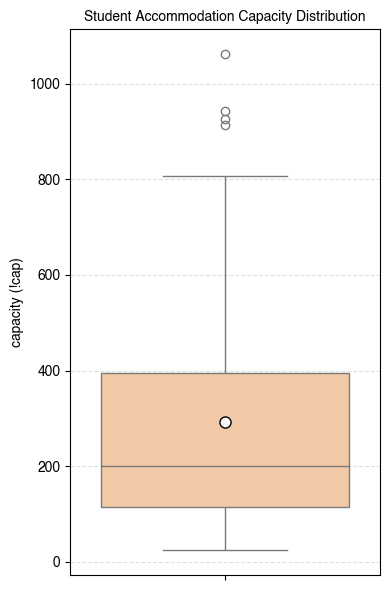

In [10]:
plt.figure(figsize=(4, 6))
sns.boxplot(
    data=pbsa_c,
    y='!cap',
    color= '#FEC89A',
    showmeans=True,
    meanprops={
        'marker': 'o',
        'markerfacecolor': 'white',
        'markeredgecolor': 'black',
        'markersize': '8'
    }
)
plt.title('Student Accommodation Capacity Distribution', fontsize=10, weight='bold')
plt.ylabel('сapacity (!cap)')
plt.grid(axis='y', linestyle='--', alpha=0.4)

save_path = os.path.join(hf, "Student Accommodation Capacity Distribution.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

*Figure XX. Student Accommodation Capacity Distribution*

The Student Accommodation Capacity Normal Distribution Histogram (Figure XX) shows that student accommodation consists of small halls of residence with fewer than 300 students, indicating fragmentation and a small scale of supply within Berlin's existing urban structure. 

Only a few large complexes exceed 600–800 places, reflecting isolated high-density developments, often located on the periphery or on redeveloped sites. 

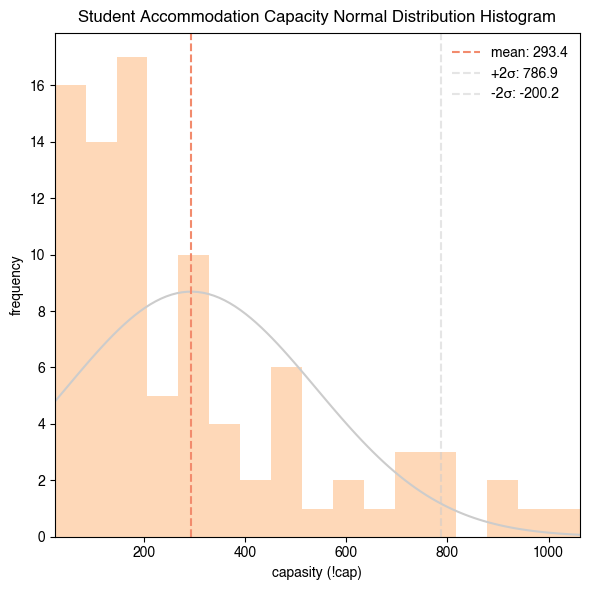

In [11]:
f, axs = plt.subplots(figsize=(6, 6)) 

#---------------------------------------- 1 ------------------------------------------------------------
x_min = pbsa_c['!cap'].min()
x_max = pbsa_c['!cap'].max()

bins = len(pbsa_c) // 5  # Number of bins based on data size
ax = axs  # First subplot: axs[0]

mu, std = norm.fit(pbsa_c['!cap'])
x = np.linspace(x_min, x_max, 100)
p = norm.pdf(x, mu, std)
nd_pbsa_c = mu-2*std
hist_area = len(pbsa_c['!cap']) * (x_max - x_min) / bins
scaled_p = p * hist_area

# Plot histogram
ax.hist(pbsa_c['!cap'], bins=bins, color='#FEC89A', alpha=0.7, density=False)

# Plot normal distribution curve
ax.plot(x, scaled_p, color='#cccccc')
ax.axvline(mu, color='#F28B6D', linestyle='--', label=f'mean: {mu:.1f}')
ax.axvline(mu + 2*std, color='#cccccc', linestyle='--', alpha=0.5, label=f'+2σ: {mu+2*std:.1f}')
ax.axvline(mu - 2*std, color='#cccccc', linestyle='--', alpha=0.5, label=f'-2σ: {mu-2*std:.1f}')

ax.set_xlim(x_min, x_max)
ax.set_xlabel('capasity (!cap)', fontsize=10)
ax.set_ylabel('frequency', fontsize=10)
ax.set_title('Student Accommodation Capacity Normal Distribution Histogram', fontsize=12, pad=8, fontweight='bold')
ax.legend(loc='best', frameon=False)

save_path = os.path.join(hf, "Student Accommodation Capacity Normal Distribution.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

*Figure XX. Student Accommodation Capacity Normal Distribution Histogram*

Price Distribution (Figure XX) shows a clear disparity between minimum and maximum student accommodation prices in Berlin, illustrating both baseline affordability constraints and significant upper-end price volatility. Minimum prices on average are 447€ ± 136€, which aligns with Berlin’s Mietspiegel, suggesting a relatively narrow—but still high—cost floor for most students. In contrast, maximum prices have multiple high-value outliers, reaching above 1,400€, indicating the presence of hight-cost or highly commodified units within the market. 

When discussing student housing prices, it is important to remember that housing is a human right. (Lefebvre, 1968), not an object of trade. The Berlin Constitution clearly state: `Everyone has the right to adequate housing. The state promotes the creation and provision of adequate housing, especially for people on low incomes, and the cultivation of condominium ownership`. Students can be seen as people of low income, who can not afford such hight-cost options.  

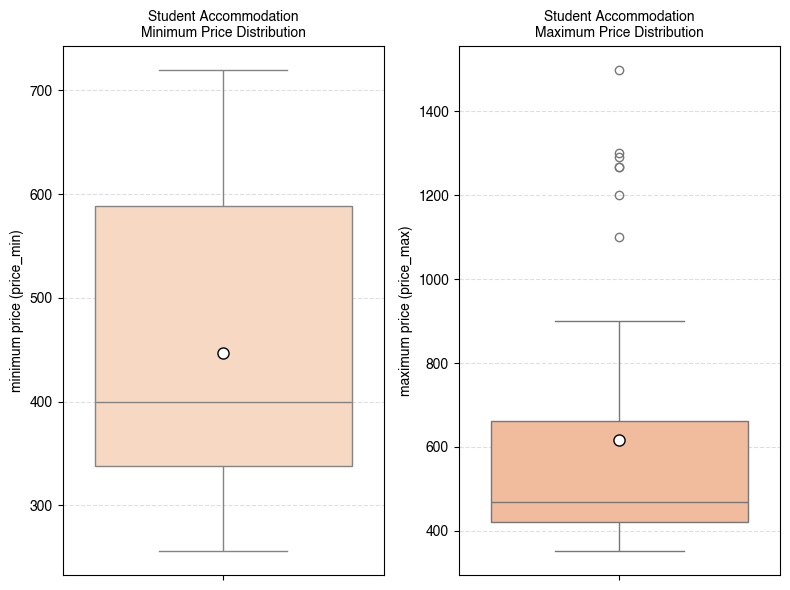

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(8, 6))   # 1 row, 2 columns

sns.boxplot(
    ax=axs[0],                          # <-- *zero‑based* index
    data=pbsa_c,
    y='price_min',
    color='#FFD7BA',
    showmeans=True,
    meanprops={
        'marker': 'o',
        'markerfacecolor': 'white',
        'markeredgecolor': 'black',
        'markersize': 8
    }
)
axs[0].set_title('Student Accommodation\nMinimum Price Distribution',
                 fontsize=10, fontweight='bold')
axs[0].set_ylabel('minimum price (price_min)')
axs[0].grid(axis='y', linestyle='--', alpha=0.4)

sns.boxplot(
    ax=axs[1],                          # <-- second subplot
    data=pbsa_c,
    y='price_max',
    color='#FFB78F',
    showmeans=True,
    meanprops={
        'marker': 'o',
        'markerfacecolor': 'white',
        'markeredgecolor': 'black',
        'markersize': 8
    }
)
axs[1].set_title('Student Accommodation\nMaximum Price Distribution',
                 fontsize=10, fontweight='bold')
axs[1].set_ylabel('maximum price (price_max)')
axs[1].grid(axis='y', linestyle='--', alpha=0.4)

save_path = os.path.join(hf, "Student Accommodation Maximum Price Distribution.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

fig.tight_layout()  
plt.show()

*Figure XX. Student Accommodation Price Distribution*

Spatial characteristics (`area_min`, `area_max`) demonstrate additional heterogeneity — living spaces range from compact studios (<12 m², σ=±4.7) to spacious shared flats (>40 m², σ=±11.2), illustrating differences in the morphology of student housing. 

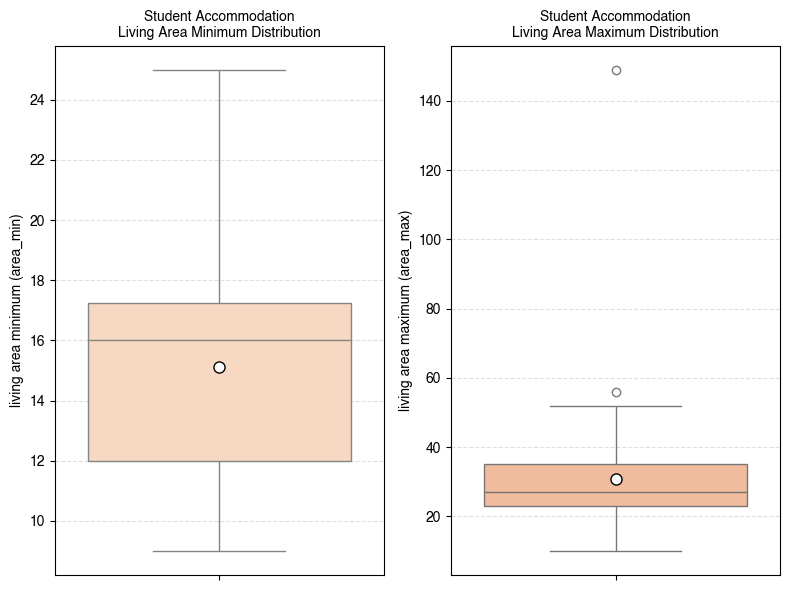

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(8, 6))   # 1 row, 2 columns

sns.boxplot(
    ax=axs[0],                          # <-- *zero‑based* index
    data=pbsa_c,
    y='area_min',
    color='#FFD7BA',
    showmeans=True,
    meanprops={
        'marker': 'o',
        'markerfacecolor': 'white',
        'markeredgecolor': 'black',
        'markersize': 8
    }
)
axs[0].set_title('Student Accommodation\nLiving Area Minimum Distribution',
                 fontsize=10, fontweight='bold')
axs[0].set_ylabel('living area minimum (area_min)')
axs[0].grid(axis='y', linestyle='--', alpha=0.4)

sns.boxplot(
    ax=axs[1],                          # <-- second subplot
    data=pbsa_c,
    y='area_max',
    color='#FFB78F',
    showmeans=True,
    meanprops={
        'marker': 'o',
        'markerfacecolor': 'white',
        'markeredgecolor': 'black',
        'markersize': 8
    }
)
axs[1].set_title('Student Accommodation\nLiving Area Maximum Distribution',
                 fontsize=10, fontweight='bold')
axs[1].set_ylabel('living area maximum (area_max)')
axs[1].grid(axis='y', linestyle='--', alpha=0.4)

save_path = os.path.join(hf, "Student Accommodation Area Distribution.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

fig.tight_layout()  
plt.show()

*Figure XX. Student Accommodation Living Area Distribution*

The significant variability (Table XX) identified at the beginning of the chapter requires additional statistical processing. The heterogeneity essentially reflects the fragmented housing market in Berlin, where supply imbalances lead to differences in housing typology across different urban areas.

For a more detailed analysis of the housing market and evaluation of numeric data, student accommodations were divided into groups according to ownership model (`own`).

### Ownership Model

Key Student Accommodation Ownership Companies (Table XX) are the state-owned companies Studierendenwerk Berlin, Berlinovo, Degewo and the private companies Home in Berlin GmbH and Campus Viva GmbH. Together, these five companies own 68.9% of the student accommodation market. 

In [14]:
summary_ownership = (pbsa_c.groupby('ownership', dropna=False)[cols_numeric].agg(['sum', 'mean', 'median', 'std']).round(2))

summary_ownership.sort_values(by=('!cap', 'sum'), ascending=False, inplace=True)

summary_ownership.head(5)

!cap                        price_min          \
                            sum    mean median     std       sum    mean   
ownership                                                                  
Studierendenwerk Berlin  9942.0  310.69  183.0  285.91   10101.0  325.84   
Berlinovo                3787.0  344.27  232.0  282.10    3940.0  437.78   
Home in Berlin GmbH      1890.0  315.00  178.5  315.15    3715.0  619.17   
Campus Viva GmbH         1108.0  554.00  554.0  359.21    1190.0  595.00   
Degewo                   1065.0  532.50  532.5  557.91       0.0     NaN   

                                       price_max                          \
                        median     std       sum     mean  median    std   
ownership                                                                  
Studierendenwerk Berlin  322.0   43.44   13552.0   437.16   422.0  59.83   
Berlinovo                410.0   78.70       0.0      NaN     NaN    NaN   
Home in Berlin GmbH      659.5   96.56     779.0   779.00   779.0    NaN   
Campus Viva GmbH         595.0  176.78    1499.0  1499.00  1499.0    NaN   
Degewo                     NaN     NaN       0.0      NaN     NaN    NaN   

                        area_min                     area_max                \
                             sum   mean median   std      sum   mean median   
ownership                                                                     
Studierendenwerk Berlin    394.0  12.71   12.0  3.63    903.0  29.13   28.0   
Berlinovo                  145.0  16.11   16.0  0.60    162.0  20.25   20.0   
Home in Berlin GmbH         91.0  15.17   13.0  4.22    102.0  25.50   26.0   
Campus Viva GmbH            38.0  19.00   19.0  1.41     72.0  36.00   36.0   
Degewo                      39.0  19.50   19.5  3.54     61.0  30.50   30.5   

                                
                           std  
ownership                       
Studierendenwerk Berlin   8.03  
Berlinovo                 2.76  
Home in Berlin GmbH       5.74  
Campus Viva GmbH         14.14  
Degewo                    7.78

*Table XX. Key Student Accommodation Ownership Companies* 

When dividing student accommodation into state and privately owned, the gap between the minimum and maximum prices (`price_min` and `price_max`) for monthly rent for different ownership models become evident. Table XX analyses the numerical fields for student accommodation according to different ownership types.

The capacity of state and private accommodation differs slightly. Nevertheless, prices for state-owned accommodation vary from €368 to €439, while privately owned accommodation costs significantly more: from €590 to €968. 

At the same time, the minimum income for students set by the Federal Foreign Office in 2025 for foreign students to obtain a visa is €992 per month. This makes private accommodation unaffordable for most international students. 

Reducing the price gap between state and private accommodation through price regulation could be part of the solution to the student housing crisis. 

In [15]:
summary_ownership_model = (
    pbsa_c
    .groupby('ownership_model', dropna=False)[cols_numeric]
    .agg(['mean', 'median', 'std']).round(2)
    .sort_index()
)

summary_ownership_model

!cap                price_min               price_max  \
                   mean median     std      mean median    std      mean   
ownership_model                                                            
Privat-Owned     295.50  245.0  205.93    590.52  600.0  96.00    968.94   
State-Owned      292.28  162.5  269.13    368.43  352.0  79.89    439.44   

                               area_min              area_max                
                median     std     mean median   std     mean median    std  
ownership_model                                                              
Privat-Owned     887.5  307.59    16.00   17.0  3.18    29.60   27.0   8.46  
State-Owned      422.0   60.25    14.72   15.0  4.36    31.29   27.0  19.65

*Table XX. Student Accommodation Ownership Model Numeric Fields Summary*

Despite their inaccessibility in terms of cost, private student accommodation accounts for 34.3% of the market supply (Figure XX). Private accommodation is not uncommon – it houses about one-fifth of all international students. This suggests that the private market should be regulated systematically, rather than on a case-by-case basis. 

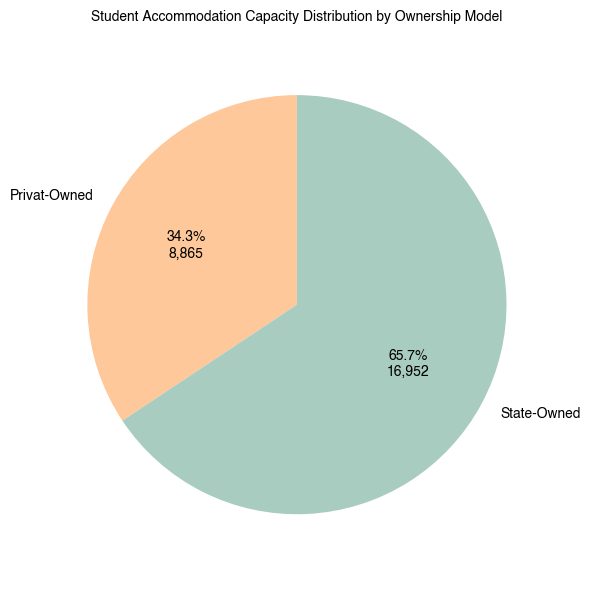

In [16]:
cap_by_own = pbsa_c.groupby('ownership_model')['!cap'].sum()

fig, ax = plt.subplots(figsize=(6,6))

def make_autopct(values):
    """Return a function that displays: `perct%  \n[count]`."""
    total = sum(values)

    def my_autopct(pct):
        # `pct` is the percent that plt.pie passes to the function
        count = int(round(pct * total / 100.0))
        return f"{pct:.1f}%\n{count:,}"      # comma as thousand‑separator

    return my_autopct

ax.pie(
    cap_by_own,
    labels=cap_by_own.index,   # Private / Public (or whatever you have)
    autopct=make_autopct(cap_by_own),         # percent to 1 decimal place
    startangle=90,             # nicer start position
    colors=['#FEC89A','#A9CCC1']   # mint + orange – change if you prefer
)
ax.set_title('Student Accommodation Capacity Distribution by Ownership Model', fontsize=10)
ax.axis('equal')                # keep the circle round

save_path = os.path.join(hf, "Student Accommodation Capacity Distribution by Ownership Model.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

*Figure XX. Student Accommodation Capacity Distribution by Ownership Model*

In [17]:
from matplotlib.colors import ListedColormap

mint_colour   = '#A9CCC1'  # light‑mint – for Private
orange_colour = '#FEC89A'

ownership_cmap = ListedColormap([ orange_colour, mint_colour])

The map (Figure XX) illustrates the spatial distribution of student housing in Berlin by ownership model, revealing clear structural patterns that contribute to the ongoing student housing crisis in the city. 

Public residences are more evenly distributed across the periphery, reflecting their role as affordable, welfare-oriented infrastructure, but their limited density indicates insufficient public capacity relative to demand. 

Private facilities are more concentrated in central areas and high-demand areas, particularly in Mitte, Friedrichshain-Kreuzberg and Charlottenburg-Wilmersdorf, reflecting market logic that prioritises profitable locations with high rents over equal access.

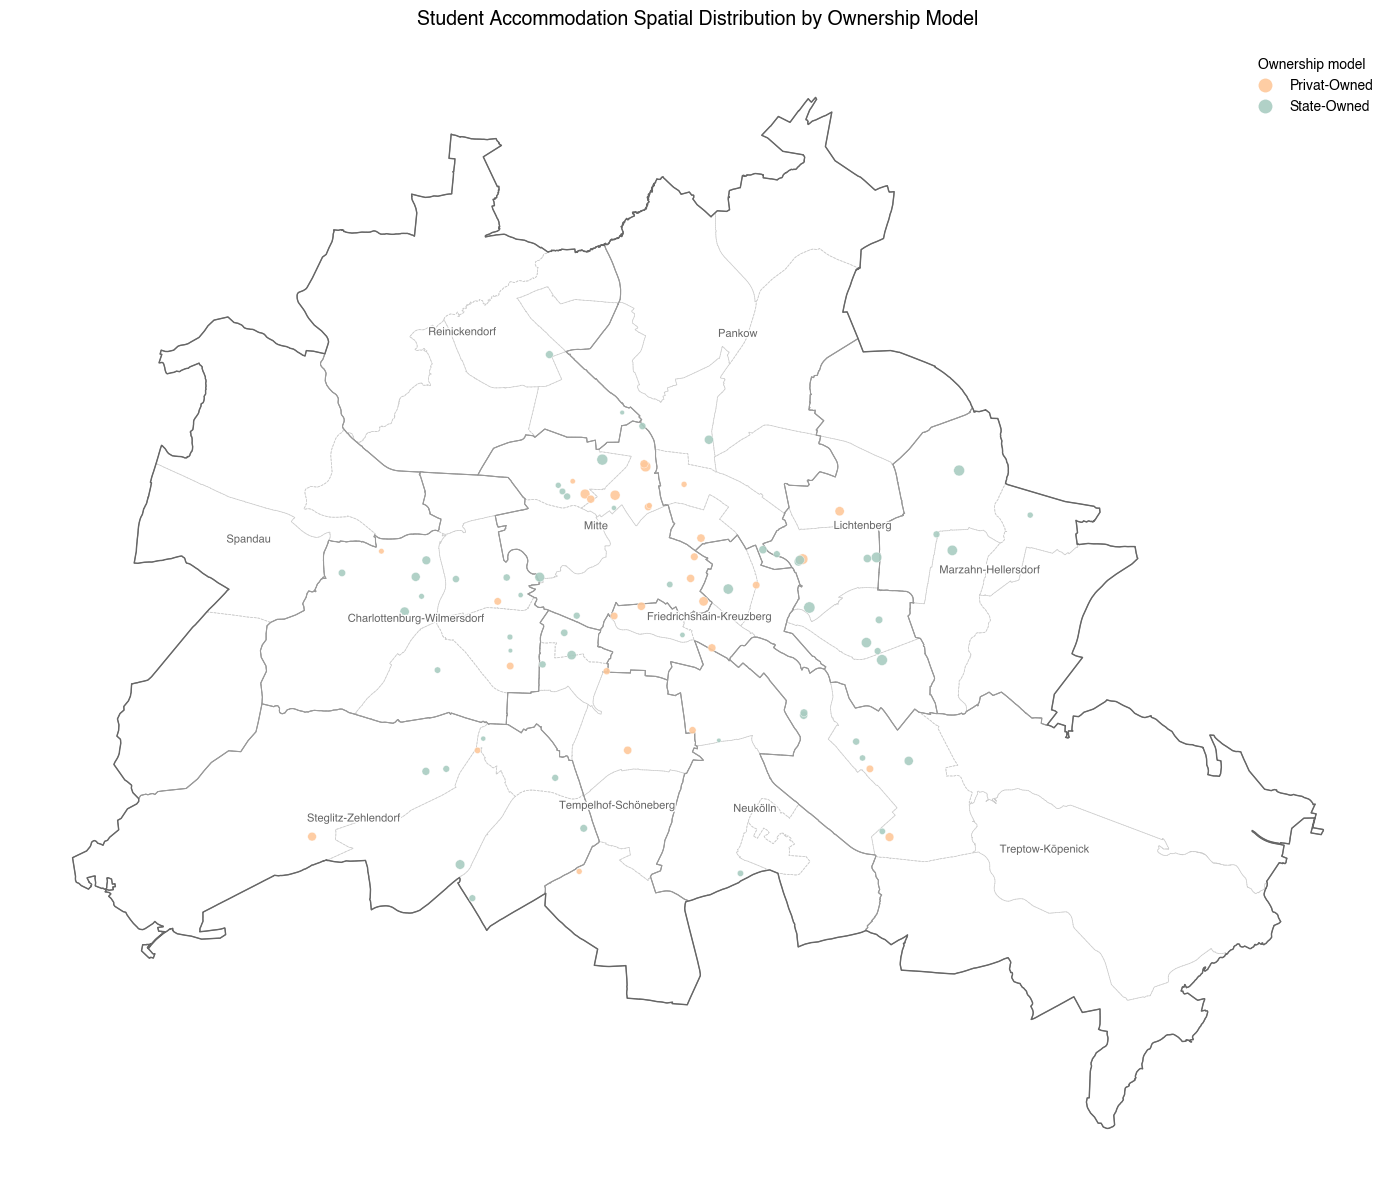

In [18]:
fig, ax  = plt.subplots(figsize=(18, 12))

pgr.plot(ax=ax, facecolor='none', edgecolor='#cccccc', linewidth=0.5, linestyle="--")
bz.plot(ax=ax, facecolor='none', edgecolor='#999999', linewidth=0.75)
for idx, row in bz.iterrows():
    centroid = row['geometry'].centroid
    txt = ax.text(
        centroid.x, centroid.y,
        str(row['namgem']),
        fontsize=8, color='#666666', ha='center', va='center'
    )
    txt.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='white'),
        path_effects.Normal()
    ])
out.plot(ax=ax, facecolor='none', edgecolor='#666666', linewidth=1)
pbsa_c.plot(
    ax=ax,
    column='ownership_model',      # <─ this forces colour by group
    cmap=ownership_cmap,           # <─ two‑colour palette
    markersize=np.sqrt(pbsa_c['!cap'])*2,   # capacity → point size
    alpha=0.9,
    edgecolor='white',
    linewidth=0.3,
    legend=True, 
    legend_kwds={'title': 'Ownership model','frameon': False       }         
    )

ax.set_title('Student Accommodation Spatial Distribution by Ownership Model', fontsize=14, pad=15, fontweight='bold')
ax.set_axis_off()

save_path = os.path.join(hf, "Student Accommodation Spatial Distribution by Ownership Model.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

*Figure XX. Student Accommodation Spatial Distribution by Ownership Model*

Two histograms (Figure XX) show that public and private student residences in Berlin have almost identical average capacities (≈290–300 places), but their distribution differs in aspects that are relevant to the housing crisis. 

Public facilities have a wider range, including several large complexes with more than 900 places (e.g. WH Coppistraße, Iranische Straße, Ludwig-Renn-Straße Hellersdorf, WH Aristotelessteig), reflecting their role in providing significant long-term public capacity.

In private student accommodation, by contrast, small and medium-sized facilities predominate, with fewer large complexes, indicating a market that tends to prioritise scattered, small investments over large-scale projects.

The public sector is at least attempting to implement large projects, while private supply remains fragmented.

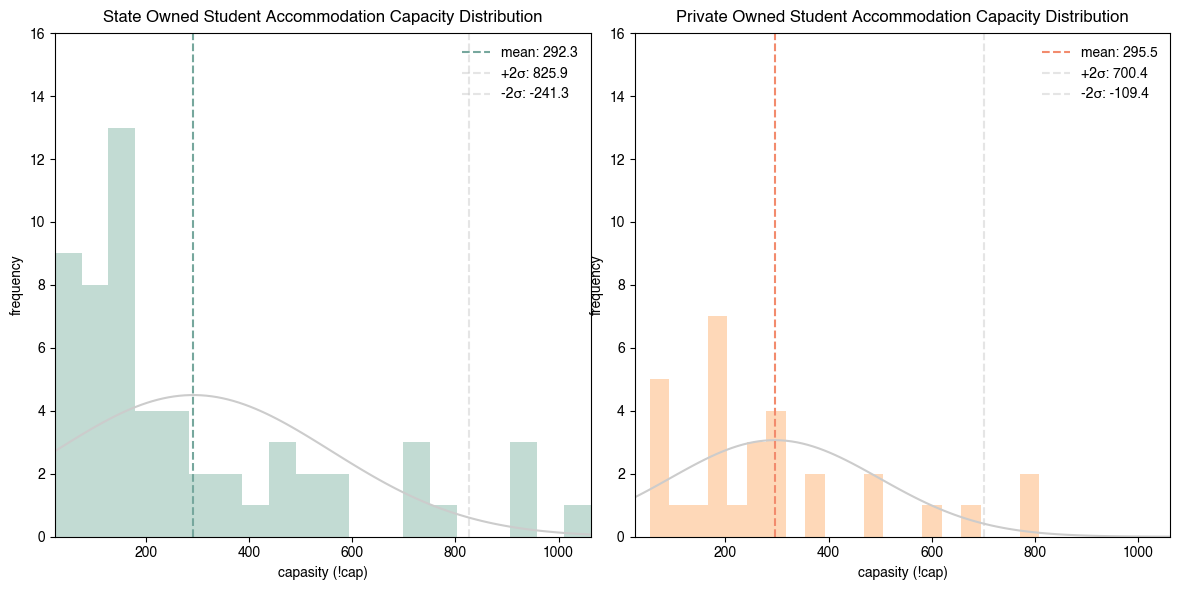

In [19]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))

pbsa_so = pbsa_c[pbsa_c['ownership_model'] == 'State-Owned']  # Filter out extreme outliers
x_min = pbsa_so['!cap'].min()
x_max = pbsa_so['!cap'].max()

# bins = len(pbsa_so)//5
bins = 20 

ax = axs[0]  

mu, std = norm.fit(pbsa_so['!cap'])
x = np.linspace(x_min, x_max, 100)
p = norm.pdf(x, mu, std)
nd_pbsa_so = mu-2*std
hist_area = len(pbsa_so['!cap']) * (x_max - x_min) / bins
scaled_p = p * hist_area

# Plot histogram
ax.hist(pbsa_so['!cap'], bins=bins, color='#A9CCC1', alpha=0.7, density=False)

# Plot normal distribution curve
ax.plot(x, scaled_p, color='#cccccc')
ax.axvline(mu, color='#76A79D', linestyle='--', label=f'mean: {mu:.1f}')
ax.axvline(mu + 2*std, color='#cccccc', linestyle='--', alpha=0.5, label=f'+2σ: {mu+2*std:.1f}')
ax.axvline(mu - 2*std, color='#cccccc', linestyle='--', alpha=0.5, label=f'-2σ: {mu-2*std:.1f}')
ax.set_xlim(x_min, x_max)
ax.set_ylim(0, 16)

ax.set_xlabel('capasity (!cap)', fontsize=10)
ax.set_ylabel('frequency', fontsize=10)
ax.set_title('State Owned Student Accommodation Capacity Distribution', fontsize=12, pad=8, fontweight='bold')
ax.legend(loc='upper right', frameon=False)
plt.tight_layout()

#----------------------------------------2------------------------------------------------------------

pbsa_po = pbsa_c[pbsa_c['ownership_model'] == 'Privat-Owned']  # Filter out extreme outliers
x_min = pbsa_so['!cap'].min()
x_max = pbsa_so['!cap'].max()

bins = 20 # Number of bins based on data size
ax = axs[1]  

mu, std = norm.fit(pbsa_po['!cap'])
x = np.linspace(x_min, x_max, 100)
p = norm.pdf(x, mu, std)
nd_pbsa_po = mu-2*std
hist_area = len(pbsa_po['!cap']) * (x_max - x_min) / bins
scaled_p = p * hist_area

# Plot histogram
ax.hist(pbsa_po['!cap'], bins=bins, color='#FEC89A', alpha=0.7, density=False)

# Plot normal distribution curve
ax.plot(x, scaled_p, color='#cccccc')
ax.axvline(mu, color='#F28B6D', linestyle='--', label=f'mean: {mu:.1f}')
ax.axvline(mu + 2*std, color='#cccccc', linestyle='--', alpha=0.5, label=f'+2σ: {mu+2*std:.1f}')
ax.axvline(mu - 2*std, color='#cccccc', linestyle='--', alpha=0.5, label=f'-2σ: {mu-2*std:.1f}')

ax.set_xlim(x_min, x_max)
ax.set_ylim(0, 16)

ax.set_xlabel('capasity (!cap)', fontsize=10)
ax.set_ylabel('frequency', fontsize=10)
ax.set_title('Private Owned Student Accommodation Capacity Distribution', fontsize=12, pad=8, fontweight='bold')
ax.legend(loc='upper right', frameon=False)


save_path = os.path.join(hf, "State and Private Owned Student Accommodation Normal Capacity Distribution Comparison.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.tight_layout
plt.show()


*Figure XX. State and Private Owned Student Accommodation Normal Capacity Distribution Comparison*

This division highlights a fundamental problem: public student housing is too infrequent and located on the outskirts to offset affordability pressures, while private housing is concentrated in the most expensive areas. As a result, students face geographical and financial mismatches, reinforcing the need for data-driven planning strategies that rebalance supply, expand capacity, and redirect development to underserved areas.

### Housing Unit Type 

In [20]:
summary_unit_type = (
    pbsa_c
    .groupby('unit_type_norm', dropna=False)[cols_numeric]
    .agg(['mean', 'median', 'std']).round(2)
    .sort_index()
)

summary_unit_type

!cap                price_min                price_max  \
                    mean median     std      mean median     std      mean   
unit_type_norm                                                               
single apartment  310.68  202.0  251.76    457.34  410.0  141.00    656.25   
double apartment  364.20  386.0  257.86    401.75  411.5  120.98    466.67   
shared apartment  133.25   73.0  177.08    380.43  342.0   83.75    383.00   
other             125.00  125.0   28.28       NaN    NaN     NaN       NaN   

                                area_min              area_max                
                 median     std     mean median   std     mean median    std  
unit_type_norm                                                                
single apartment  504.5  324.31    15.46   16.0  4.12    31.28   27.5  17.62  
double apartment  425.0   74.78    15.00   13.5  4.24    40.25   40.5  13.38  
shared apartment  367.0   38.79    12.14   12.0  2.12    19.83   20.0   6.65  
other               NaN     NaN      NaN    NaN   NaN      NaN    NaN    NaN

Full descriptive statistics on student accommodation are available for review in the Materials & Data chapter. 

In [21]:
output_path = r"../outputs/2.3_descriptive_market_statistics/student_acomodation_statictics.xlsx" 

# Write DataFrames to separate sheets in one Excel file
with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    summary.to_excel(writer, sheet_name='common_statistics')
    summary_ownership.to_excel(writer, sheet_name='by_ownership')
    summary_ownership_model.to_excel(writer, sheet_name='by_ownership_model')
    summary_unit_type.to_excel(writer, sheet_name='by_unit_type')

# Higher Education Universities Students Demand

The higher education universities' geospatial data, obtained as a result of Urban Data Mining, served as a base for statistical research.

In [22]:
cf = r"../inputs/2.3_descriptive_market_statistics/uni_c.gpkg"
uni_c = gpd.read_file(cf)

### Common Statictics 

In the case of Higher Education Universities, the numerical data are the number of German students (`!s_de`), the number of foreign students (`!s_aus`) and the total number of students (`!s_all`). 

In [23]:
cols_numeric = ['!s_all', '!s_de', '!s_aus']

Higher Education Universities Data (Table XX) shows a sharp difference in student numbers between universities in Berlin. The average university enrolment is 3,720 students, but a typical university (median 842 places) is 4.4 times smaller. This means that several large universities take on the main part of the load (such as Free University, Humboldt University and Technical University of Berlin).

Foreign students make up 24.1% of the total, meaning that one in five students in Berlin is a foreigner. Comparing the standard deviations for German and foreign students, one can see segmentation based on nationality, which manifests itself in a 3.3-times higher dispersion of German students than foreign students, revealing a cluster model of foreign student placement in large state universities. It is noteworthy that Free University (8,280 foreign students), Humboldt University (6,415 foreign students) and Technical University of Berlin (10,262 foreign students) account for 24,957 foreign students, or 51.5% of total international student demand.

In [24]:
summary = uni_c[cols_numeric].agg(['mean', 'median', 'std', 'sum'])
summary = summary.T.round(2)

summary

,mean,median,std,sum
!s_all,3720.15,842.0,8498.32,200888.0
!s_de,2822.80,489.0,6604.27,152431.0
!s_aus,897.35,172.5,1999.27,48457.0


*Table XX. Higher Education Universities Numeric Fields Summary*

Free University, Humboldt University and Technical University Berlin are exceptions to the rule (or so-called ‘statistical outliers’). Most universities have up to 600 students. Thus, Higher Education Universities Students Demand Distribution (Figure XX) is far from normal. 

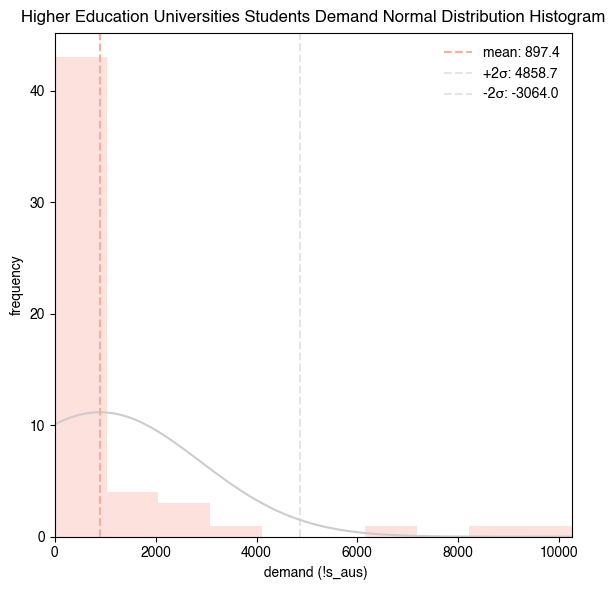

In [25]:
f, axs = plt.subplots(figsize=(6, 6)) 

#---------------------------------------- 1 ------------------------------------------------------------
x_min = uni_c['!s_aus'].min()
x_max = uni_c['!s_aus'].max()

bins = len(uni_c) // 5  # Number of bins based on data size
ax = axs  # First subplot: axs[0]

mu, std = norm.fit(uni_c['!s_aus'])
x = np.linspace(x_min, x_max, 100)
p = norm.pdf(x, mu, std)
nd_uni_c = mu-2*std
hist_area = len(uni_c['!s_aus']) * (x_max - x_min) / bins
scaled_p = p * hist_area

# Plot histogram
ax.hist(uni_c['!s_aus'], bins=bins, color='#FCD5CE', alpha=0.7, density=False)

# Plot normal distribution curve
ax.plot(x, scaled_p, color='#cccccc')
ax.axvline(mu, color='#F8AD9D', linestyle='--', label=f'mean: {mu:.1f}')
ax.axvline(mu + 2*std, color='#cccccc', linestyle='--', alpha=0.5, label=f'+2σ: {mu+2*std:.1f}')
ax.axvline(mu - 2*std, color='#cccccc', linestyle='--', alpha=0.5, label=f'-2σ: {mu-2*std:.1f}')

ax.set_xlim(x_min, x_max)
ax.set_xlabel(' demand (!s_aus)', fontsize=10)
ax.set_ylabel('frequency', fontsize=10)
ax.set_title('Higher Education Universities Students Demand Normal Distribution Histogram', fontsize=12, pad=8, fontweight='bold')
ax.legend(loc='best', frameon=False)

save_path = os.path.join(hf, "Higher Education Universities Students Demand Normal Distribution Histogram.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

*Figure XX. Higher Education Universities Students Demand Normal Distribution Histogram*

In order to gain a deeper understanding of the imbalance in supply, by analogy with student accommodations, higher education universities can be divided into two groups based on their ownership model (`own`): Public and Private Universities. 

### Ownership Model

Higher Education Universities Ownership Model Numeric Fields Summary (Figure XX) shows a dramatic structural difference between public and private higher education institutions in Berlin. Public universities dominate the academic landscape, accepting an average of more than 9,000 students per institution, while private universities accept fewer than 1,000 students. This gap persists among both German and foreign students: public universities enrol the majority of German students (an average of ≈ 7,100) and attract significantly more foreign students (an average of ≈ 2,000) than private institutions. 

The much higher overall figures and variability in the public sector highlight the concentrated demand pressure on public universities, which are the main drivers of the student housing market.

In [26]:
summary_ownership_model = (
    uni_c
    .groupby('own', dropna=False)[cols_numeric]
    .agg(['mean', 'median', 'std', 'sum']).round(2)
    .sort_index()
)

summary_ownership_model

!s_all                                !s_de          \
                      mean  median       std       sum     mean  median   
own                                                                       
Privat University   804.89   597.0    727.67   28171.0   498.49   267.0   
Public University  9090.37  4226.0  12832.96  172717.0  7104.42  2805.0   

                                       !s_aus                           
                       std       sum     mean median      std      sum  
own                                                                     
Privat University   584.14   17447.0   306.40  102.0   493.02  10724.0  
Public University  9895.76  134984.0  1985.95  400.0  3062.69  37733.0

*Table XX. Higher Education Universities Ownership Model Numeric Fields Summary*

Private universities contribute less significantly to the total number of students (Figure XX). Nevertheless, 22.1% of foreign students choose private universities for their education. Of all students at private universities, 38% are foreigners (vs. 22% at state universities). 

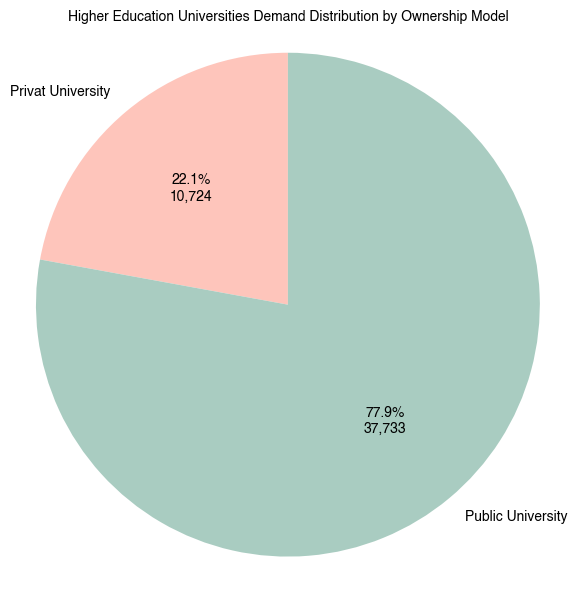

In [27]:
stud_aus_by_own = uni_c.groupby('own')['!s_aus'].sum()

fig, ax = plt.subplots(figsize=(6,6))

def make_autopct(values):
    """Return a function that displays: `perct%  \n[count]`."""
    total = sum(values)

    def my_autopct(pct):
        # `pct` is the percent that plt.pie passes to the function
        count = int(round(pct * total / 100.0))
        return f"{pct:.1f}%\n{count:,}"      # comma as thousand‑separator

    return my_autopct

ax.pie(
    stud_aus_by_own,
    labels=stud_aus_by_own.index,   # Private / Public (or whatever you have)
    autopct=make_autopct(stud_aus_by_own),         # percent to 1 decimal place
    startangle=90,             # nicer start position
    colors=['#FEC5BB','#A9CCC1']   # mint + orange – change if you prefer
)
ax.set_title('Higher Education Universities Demand Distribution by Ownership Model', fontsize=10)
ax.axis('equal')                # keep the circle round

save_path = os.path.join(hf, "Higher Education Universities Demand Distribution by Ownership Model.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

*Figure XX. Higher Education Universities Demand Distribution by Ownership Model*

The spatial distribution of higher education institutions in Berlin (Figure XX) shows a strong central concentration of private universities, in contrast to the more dispersed location of public universities throughout the city. 

Private universities are mainly concentrated in Mitte, Charlottenburg-Wilmersdorf and Friedrichshain-Kreuzberg – areas that are already characterised by high demand for housing – while public universities occupy both central areas and more peripheral areas such as Lichtenberg, Steglitz-Zehlendorf and Treptow-Köpenick. This uneven geography increases spatial inequality in the demand for student housing: large public universities create high pressure on the housing market across the city, while private universities add local spikes in demand in already highly densely populated central areas.

For large public universities, state-owned dormitories remain a priority, while the private sector requires integration into the urban housing ecosystem and lower prices as a market driver that is developing faster than the public sector. 

The map highlights a broader structural problem: the spatial logic of Berlin's university system does not correspond to the distribution of student housing, exacerbating the city's ongoing student housing crisis.

In [28]:
from matplotlib.colors import ListedColormap

mint_colour   = '#A9CCC1'  # light‑mint – for Private
orange_colour = '#FCD5CE'

ownership_cmap = ListedColormap([ orange_colour, mint_colour])

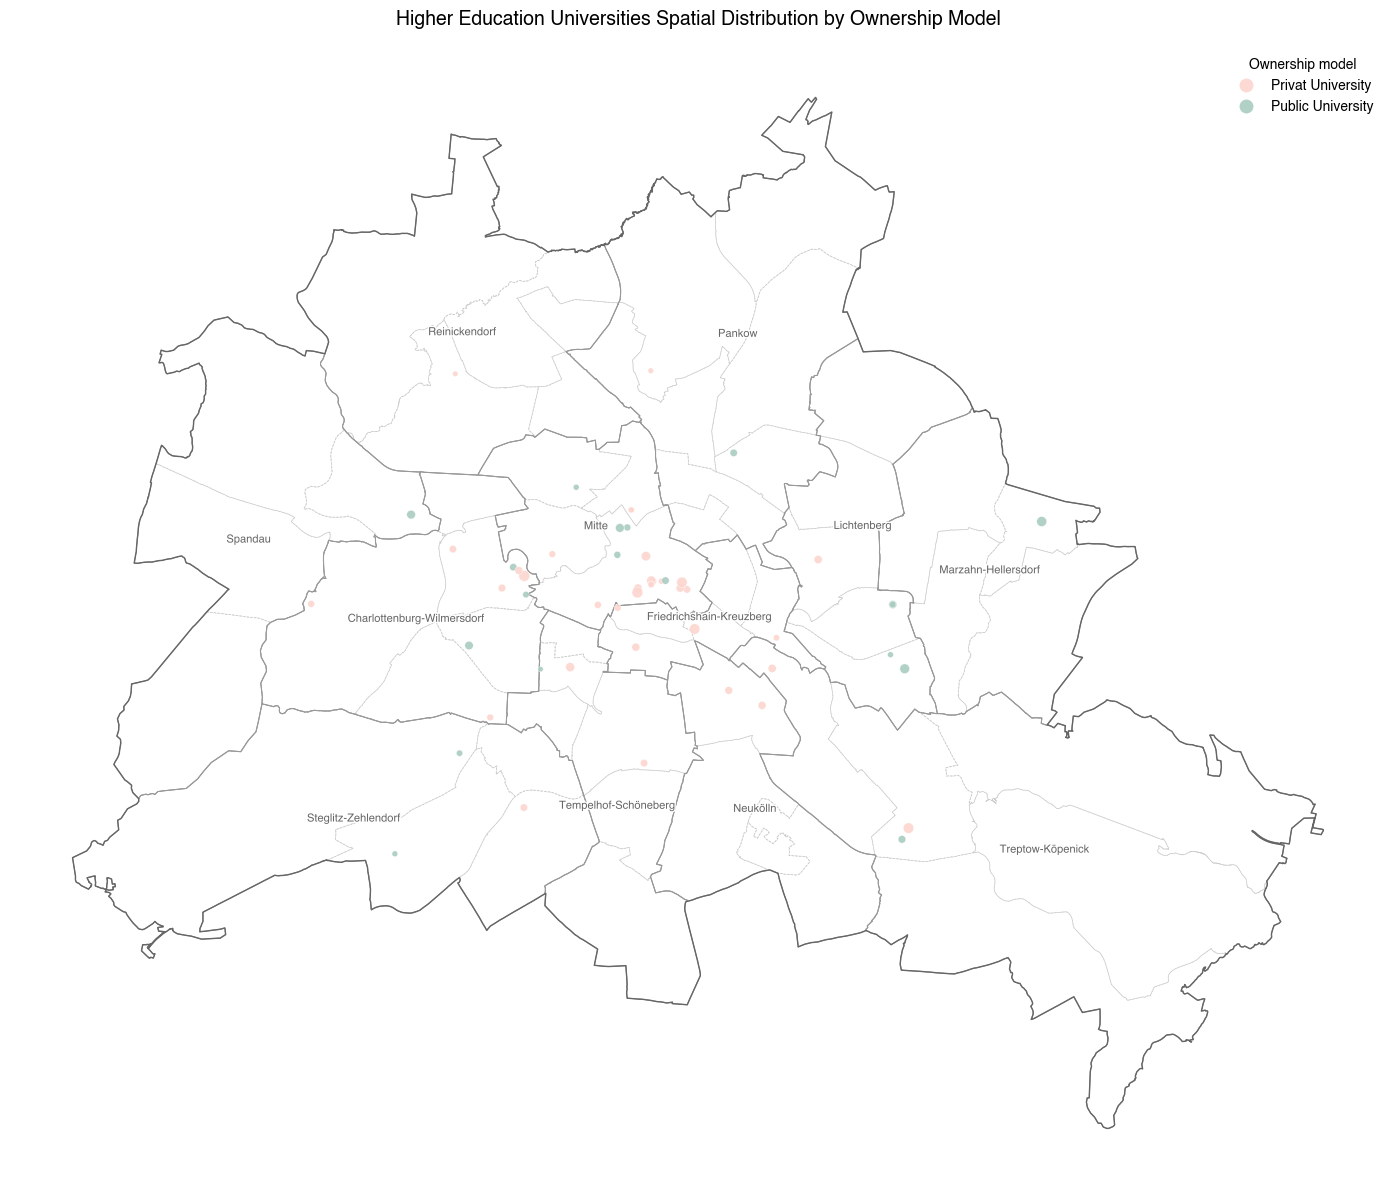

In [29]:
fig, ax  = plt.subplots(figsize=(18, 12))

pgr.plot(ax=ax, facecolor='none', edgecolor='#cccccc', linewidth=0.5, linestyle="--")
bz.plot(ax=ax, facecolor='none', edgecolor='#999999', linewidth=0.75)
for idx, row in bz.iterrows():
    centroid = row['geometry'].centroid
    txt = ax.text(
        centroid.x, centroid.y,
        str(row['namgem']),
        fontsize=8, color='#666666', ha='center', va='center'
    )
    txt.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='white'),
        path_effects.Normal()
    ])
out.plot(ax=ax, facecolor='none', edgecolor='#666666', linewidth=1)
uni_c.plot(
    ax=ax,
    column='own',      # <─ this forces colour by group
    cmap=ownership_cmap,           # <─ two‑colour palette
    markersize=np.sqrt(pbsa_c['!cap'])*2,   # capacity → point size
    alpha=0.9,
    edgecolor='white',
    linewidth=0.3,
    legend=True, 
    legend_kwds={'title': 'Ownership model','frameon': False       }         
    )

ax.set_title('Higher Education Universities Spatial Distribution by Ownership Model', fontsize=14, pad=15, fontweight='bold')
ax.set_axis_off()

save_path = os.path.join(hf, "Higher Education Universities Spatial Distribution by Ownership Model.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

*Figure XX. Higher Education Universities Spatial Distribution by Ownership Model*

Two histograms (Figure XX) show that public and private universities in Berlin have different demand indicators: 1,986 for public universities and 306 for private universities.

Public universities have a wider range, including several large complexes with more than 8,000 students. (e.g., Technical University of Berlin and Free University of Berlin), indicating a high concentration of international demand in a limited number of campuses.

In private halls of residence, on the other hand, the distribution is more compact, but still spread out. The vast majority of private universities have low or medium demand, while large complexes have up to 2,500 international students.

The contrast between the two distributions confirms that the housing demand of international students in Berlin is unevenly distributed, creating local areas of market overload.

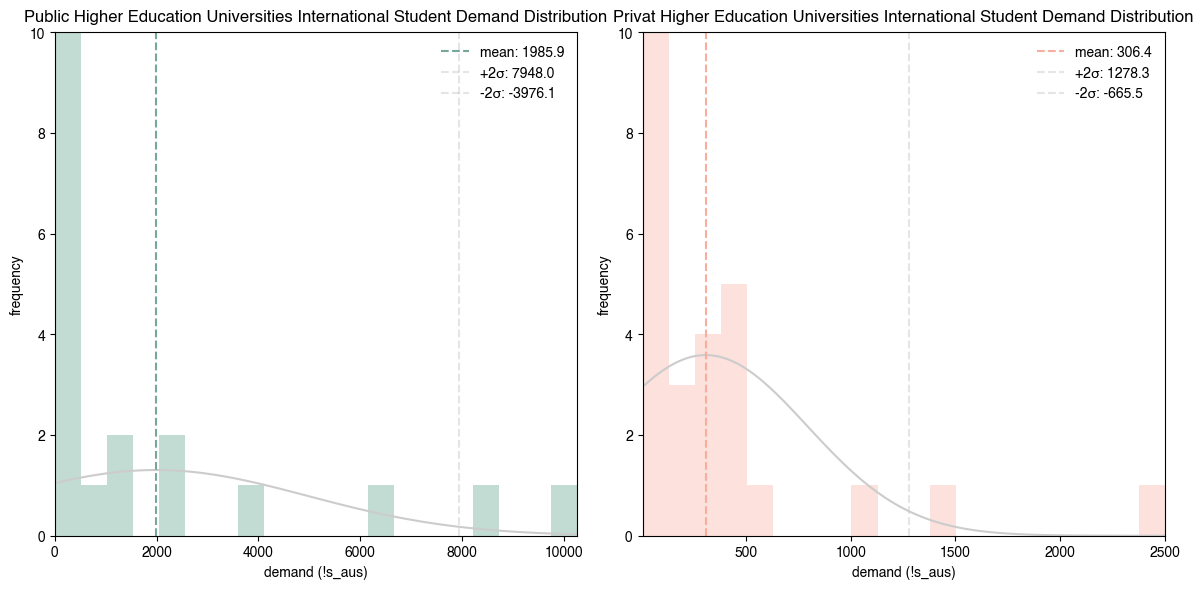

In [30]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))

uni_so = uni_c[uni_c['own'] == 'Public University']  # Filter out extreme outliers
x_min = uni_so['!s_aus'].min()
x_max = uni_so['!s_aus'].max()

# bins = len(uni_so)//5
bins = 20 

ax = axs[0]  

mu, std = norm.fit(uni_so['!s_aus'])
x = np.linspace(x_min, x_max, 100)
p = norm.pdf(x, mu, std)
nd_uni_so = mu-2*std
hist_area = len(uni_so['!s_aus']) * (x_max - x_min) / bins
scaled_p = p * hist_area

# Plot histogram
ax.hist(uni_so['!s_aus'], bins=bins, color='#A9CCC1', alpha=0.7, density=False)

# Plot normal distribution curve
ax.plot(x, scaled_p, color='#cccccc')
ax.axvline(mu, color='#76A79D', linestyle='--', label=f'mean: {mu:.1f}')
ax.axvline(mu + 2*std, color='#cccccc', linestyle='--', alpha=0.5, label=f'+2σ: {mu+2*std:.1f}')
ax.axvline(mu - 2*std, color='#cccccc', linestyle='--', alpha=0.5, label=f'-2σ: {mu-2*std:.1f}')

ax.set_xlim(x_min, x_max)
ax.set_ylim(0, 10)

ax.set_xlabel('demand (!s_aus)', fontsize=10)
ax.set_ylabel('frequency', fontsize=10)
ax.set_title('Public Higher Education Universities International Student Demand Distribution', fontsize=12, pad=8, fontweight='bold')
ax.legend(loc='upper right', frameon=False)
plt.tight_layout()

#----------------------------------------2------------------------------------------------------------

uni_po = uni_c[uni_c['own'] == 'Privat University']  # Filter out extreme outliers
x_min = uni_po['!s_aus'].min()
x_max = uni_po['!s_aus'].max()

bins = 20 # Number of bins based on data size
ax = axs[1]  

mu, std = norm.fit(uni_po['!s_aus'])
x = np.linspace(x_min, x_max, 100)
p = norm.pdf(x, mu, std)
nd_uni_po = mu-2*std
hist_area = len(uni_po['!s_aus']) * (x_max - x_min) / bins
scaled_p = p * hist_area

# Plot histogram
ax.hist(uni_po['!s_aus'], bins=bins, color='#FCD5CE', alpha=0.7, density=False)

# Plot normal distribution curve
ax.plot(x, scaled_p, color='#cccccc')
ax.axvline(mu, color='#F8AD9D', linestyle='--', label=f'mean: {mu:.1f}')
ax.axvline(mu + 2*std, color='#cccccc', linestyle='--', alpha=0.5, label=f'+2σ: {mu+2*std:.1f}')
ax.axvline(mu - 2*std, color='#cccccc', linestyle='--', alpha=0.5, label=f'-2σ: {mu-2*std:.1f}')

ax.set_xlim(x_min, x_max)
ax.set_ylim(0, 10)

ax.set_xlabel('demand (!s_aus)', fontsize=10)
ax.set_ylabel('frequency', fontsize=10)
ax.set_title('Privat Higher Education Universities International Student Demand Distribution', fontsize=12, pad=8, fontweight='bold')
ax.legend(loc='upper right', frameon=False)

save_path = os.path.join(hf, "Public and Private Owned Higher Education Universities International Student Demand Distribution Comparison.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

*Figure XX. Public and Private Owned Higher Education Universities International Student Demand Distribution Comparison*

### University Type

In [31]:
summary_uni_type = (
    uni_c
    .groupby('stud', dropna=False)[cols_numeric]
    .agg(['mean', 'median', 'std', 'sum'
          ]).round(2)
    .sort_index()
)

summary_uni_type

!s_all                              \
                                     mean  median       std       sum   
stud                                                                    
Art Universities\t                1217.40   539.0   1698.64    6087.0   
Religious Universities             753.40   729.0    708.41    3767.0   
Universities                      8679.93  4313.0  11794.71  130199.0   
Universities of Applied Sciences  2097.76   820.0   6933.15   60835.0   

                                    !s_de                              !s_aus  \
                                     mean  median      std       sum     mean   
stud                                                                            
Art Universities\t                 765.60   178.0  1152.23    3828.0   451.80   
Religious Universities             695.60   708.0   684.04    3478.0    57.80   
Universities                      6832.07  3791.0  9005.54  102481.0  1847.87   
Universities of Applied Sciences  1470.48   338.0  5448.32   42644.0   627.28   

                                                           
                                 median      std      sum  
stud                                                       
Art Universities\t                278.0   558.91   2259.0  
Religious Universities             76.0    39.35    289.0  
Universities                      465.0  2951.42  27718.0  
Universities of Applied Sciences  188.0  1563.56  18191.0

Full descriptive statistics on student accommodation are available for review in the Materials and Data Chapter. 

In [32]:
output_path = r"../outputs/2.3_descriptive_market_statistics/higher_education_universities.xlsx" 

# Write DataFrames to separate sheets in one Excel file
with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    summary.to_excel(writer, sheet_name='common_statistics')
    summary_ownership_model.to_excel(writer, sheet_name='by_ownership_model')
    summary_uni_type.to_excel(writer, sheet_name='by_uni_type')